In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_5048/3202773982.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Catalogues of clusters and photon lists:

In [2]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


Stacked image of all slices in the lightcone:

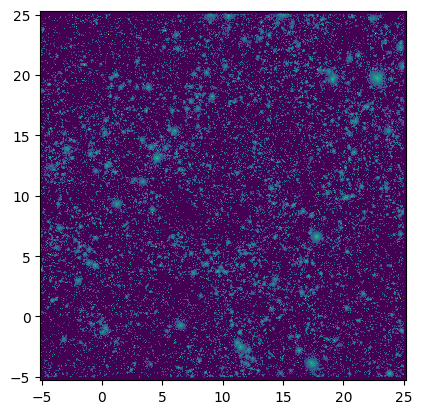

In [3]:
t_all = pd.DataFrame([])
for p in phlists:
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/"+p, hdu=2)
    t_all = vstack([t_all, t])
    
plt.hist2d(t_all["RA"], t_all["DEC"], bins=2000, norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

### Binning clusters:

In [4]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Catalogue of galaxies:

In [5]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


### Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
17964,83,0.362858,0.386705,0.992546,0.007788,2.471400e+14,0.119892,0.119569,1.200570e+14,632.238,4.273180e+12,1.064140e+13,2.30589,0.487051,0.000002,1.864380e+14,993.667,0


<Figure size 640x480 with 0 Axes>

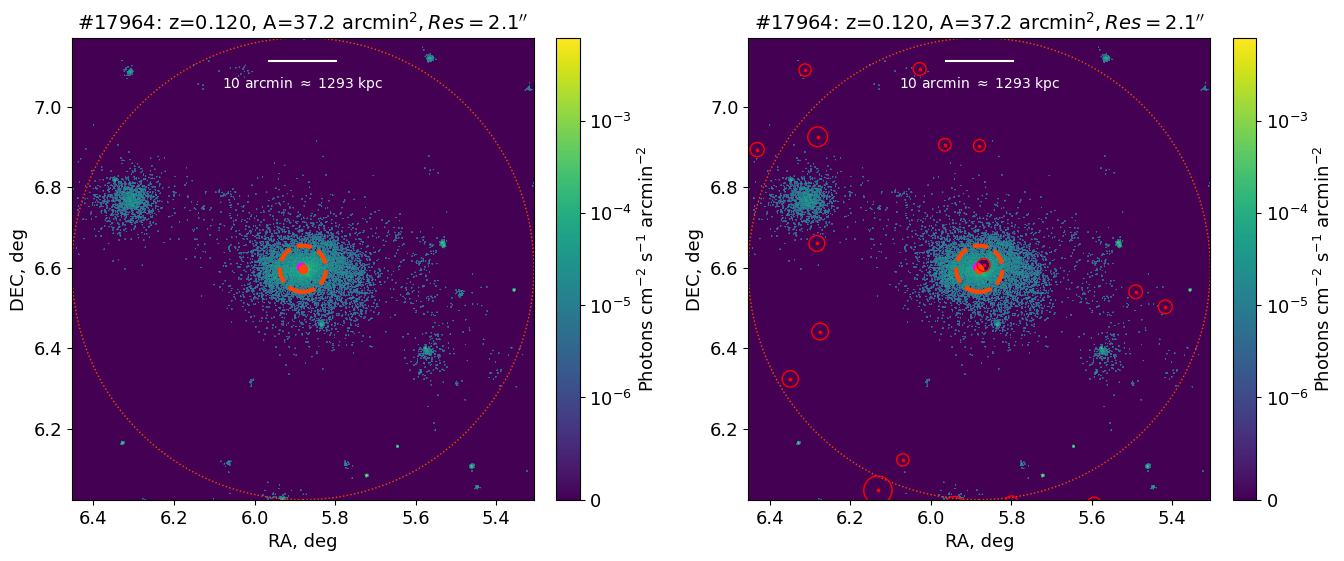

In [165]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))
plt.tight_layout()

cl_num = 17964

display(clusters[clusters.index==cl_num])

plt.subplot(121)
pho_hist1 = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

plt.subplot(122)
pho_hist2, msk = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=True, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

#print(sum(pho_hist1.flatten()), sum(pho_hist2.flatten()))
#display(plist1, plist2)

plt.show()

### Drawing panels:

In [ ]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('panels_filtered.png', format='png', dpi=100, bbox_inches='tight')
plt.close()
plt.show()

#### This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 2000 pixels in length) to obtain the flux in corresponding units.

### Filtering of images:

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

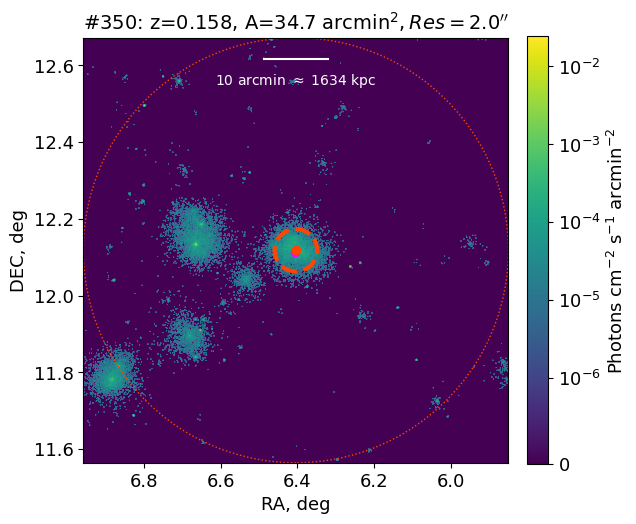

In [85]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001, 
                                     ARF_weights=False)

plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

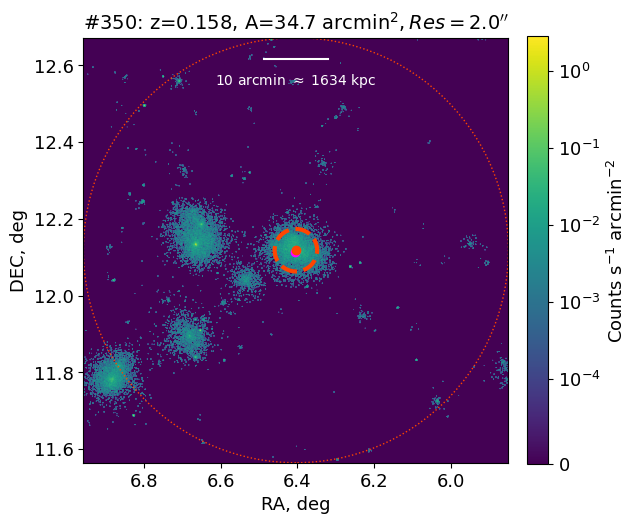

In [86]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty1 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001,
                                     ARF_weights=True)
plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

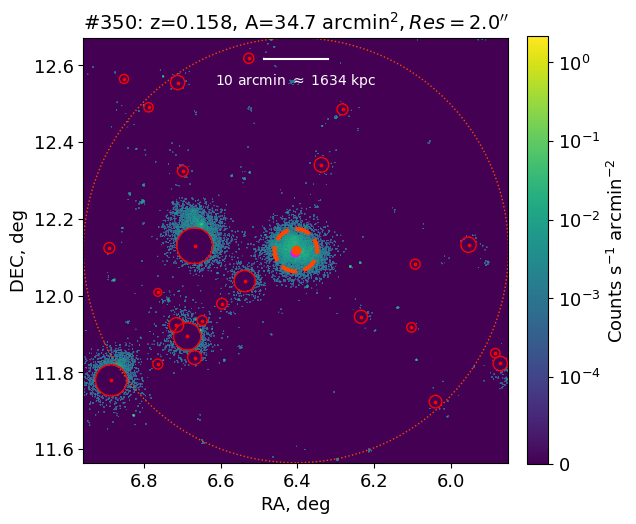

In [90]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty2, msk = extract_photons_from_cluster(cl_num, 
                                          delete_superfluous=True, 
                                          draw=True,
                                          histlen=2001,
                                          ARF_weights=True)
plt.show()

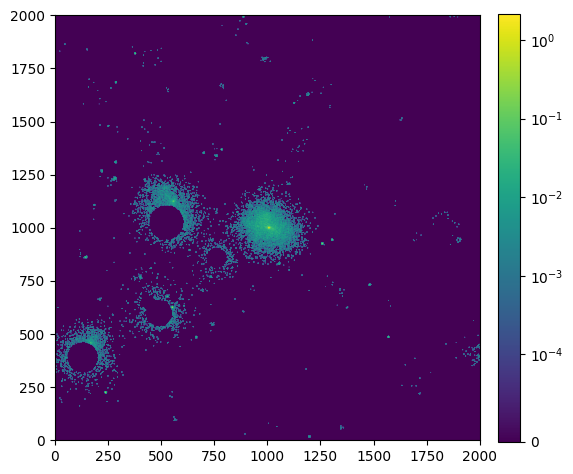

In [91]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(tyty2*(1-msk))), origin='lower', norm=matplotlib.colors.SymLogNorm(linthresh=0.0001, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

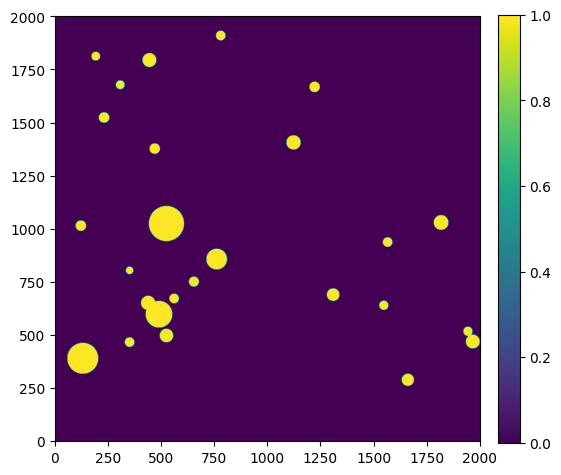

In [92]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(msk)), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

### Calculating brightness profile for one cluster (which is above):

Original:

  0%|          | 0/14 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

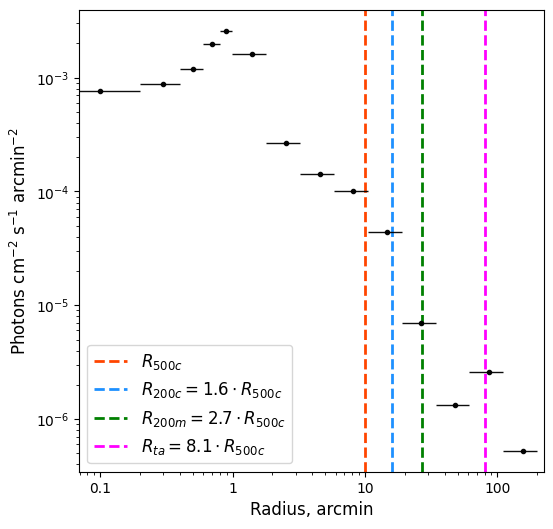

In [97]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=tyty0,
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=False)

plt.show()

  0%|          | 0/14 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

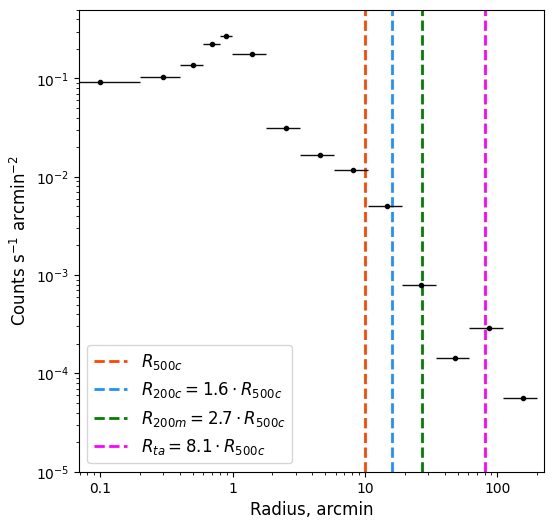

In [98]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=np.rot90(tyty1),
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

Filtered:

  0%|          | 0/14 [00:00<?, ?it/s]

Total brightness inside the ring: 0.4574706493928016
Total area of ring in pixels: 5
Area to exclude: 0.0
Total brightness after filtering: 0.4574706493928016
Total area of ring excluding masked regions: 5.0


<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

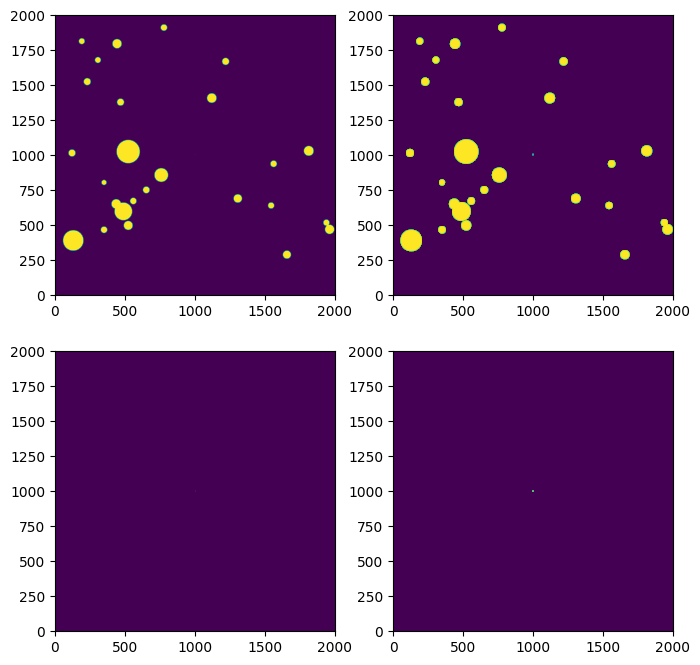

Total brightness inside the ring: 1.2380456981261403
Total area of ring in pixels: 12
Area to exclude: 0.0
Total brightness after filtering: 1.2380456981261403
Total area of ring excluding masked regions: 12.0


<Figure size 600x600 with 0 Axes>

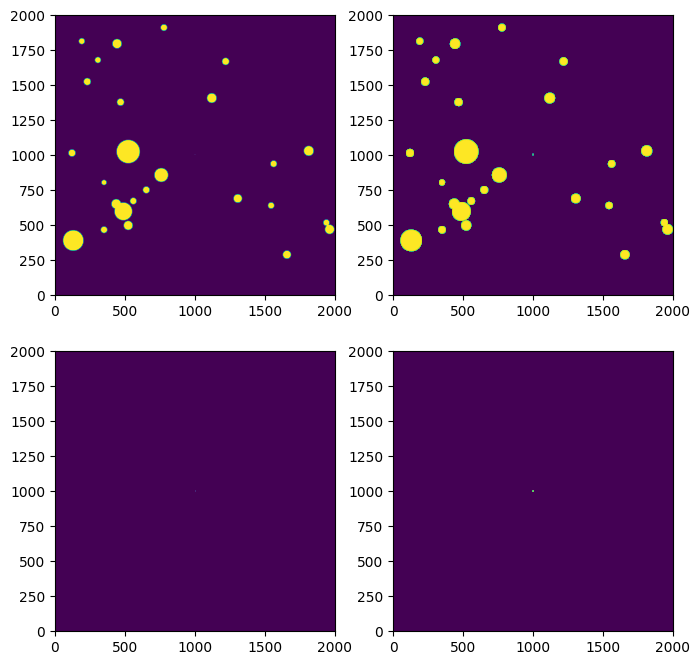

Total brightness inside the ring: 2.7302603598669615
Total area of ring in pixels: 20
Area to exclude: 0.0
Total brightness after filtering: 2.730260359866961
Total area of ring excluding masked regions: 20.0


<Figure size 600x600 with 0 Axes>

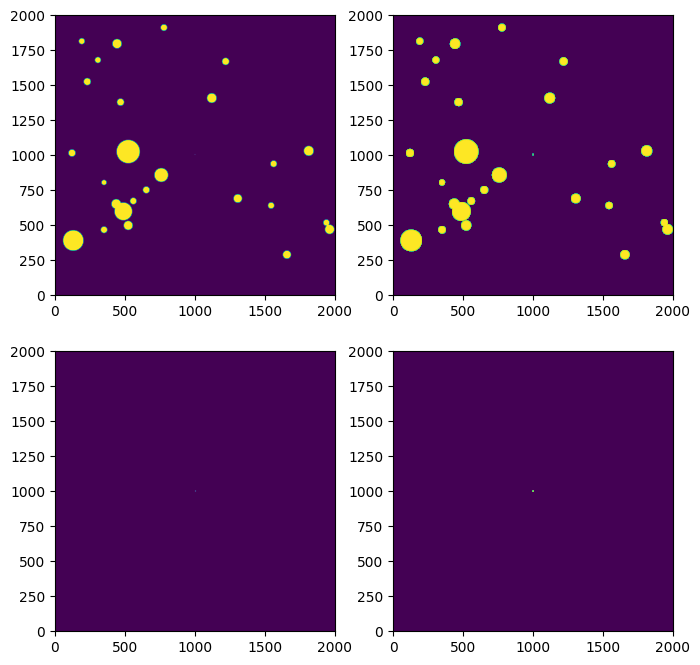

Total brightness inside the ring: 5.381577153054717
Total area of ring in pixels: 24
Area to exclude: 0.0
Total brightness after filtering: 5.381577153054717
Total area of ring excluding masked regions: 24.0


<Figure size 600x600 with 0 Axes>

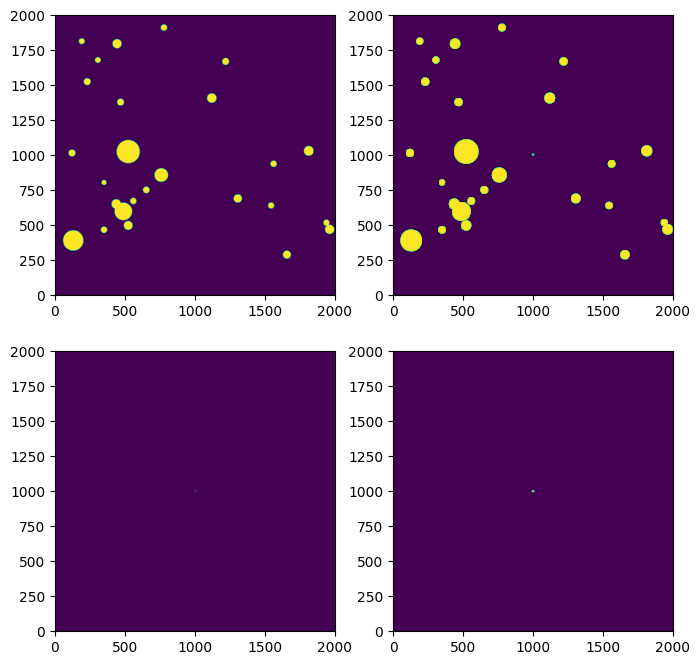

Total brightness inside the ring: 9.819408744815364
Total area of ring in pixels: 36
Area to exclude: 0.0
Total brightness after filtering: 9.819408744815366
Total area of ring excluding masked regions: 36.0


<Figure size 600x600 with 0 Axes>

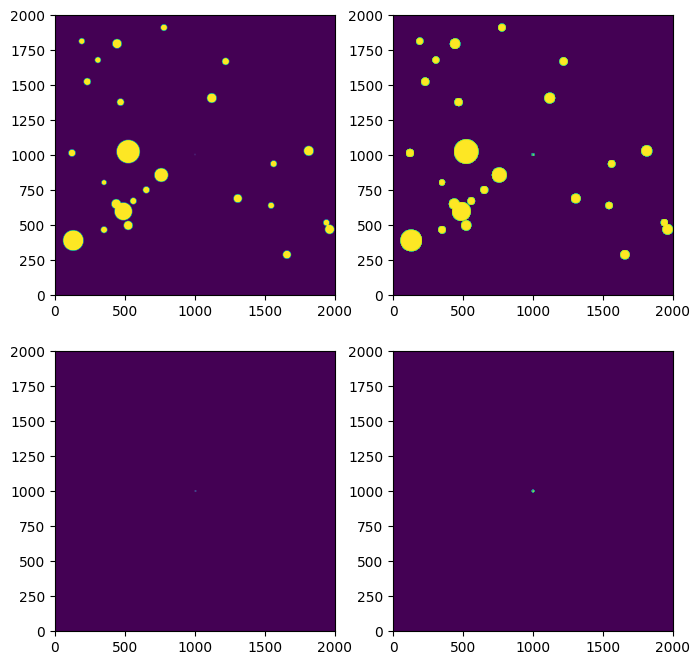

Total brightness inside the ring: 32.36788743394555
Total area of ring in pixels: 184
Area to exclude: 0.0
Total brightness after filtering: 32.36788743394555
Total area of ring excluding masked regions: 184.0


<Figure size 600x600 with 0 Axes>

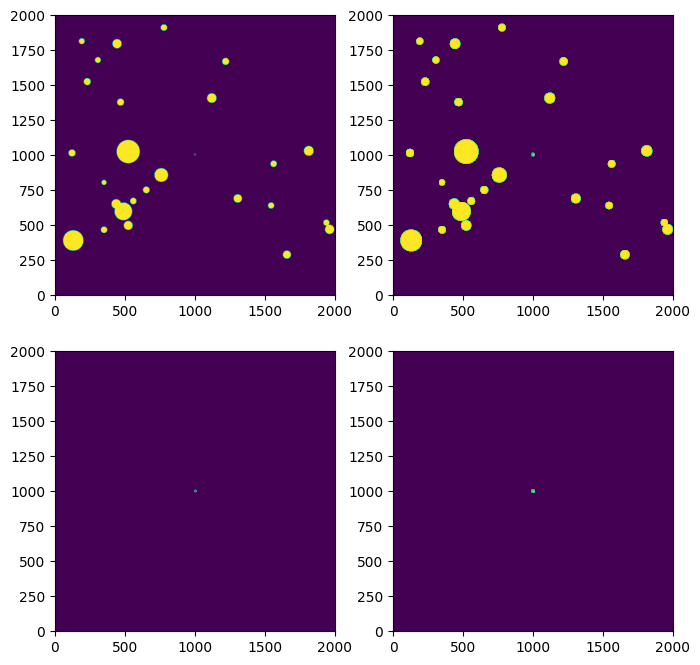

Total brightness inside the ring: 18.254785308825443
Total area of ring in pixels: 576
Area to exclude: 0.0
Total brightness after filtering: 18.254785308825433
Total area of ring excluding masked regions: 576.0


<Figure size 600x600 with 0 Axes>

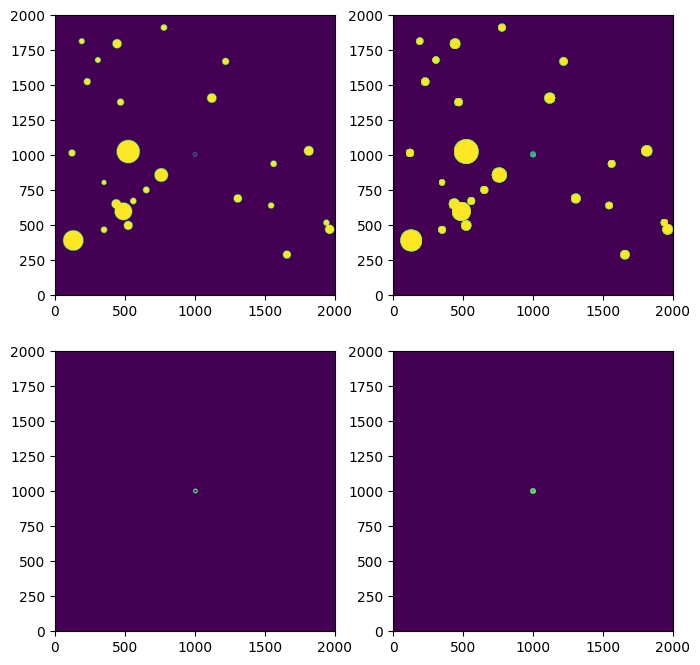

Total brightness inside the ring: 31.22478353711707
Total area of ring in pixels: 1872
Area to exclude: 0.0
Total brightness after filtering: 31.224783537117084
Total area of ring excluding masked regions: 1872.0


<Figure size 600x600 with 0 Axes>

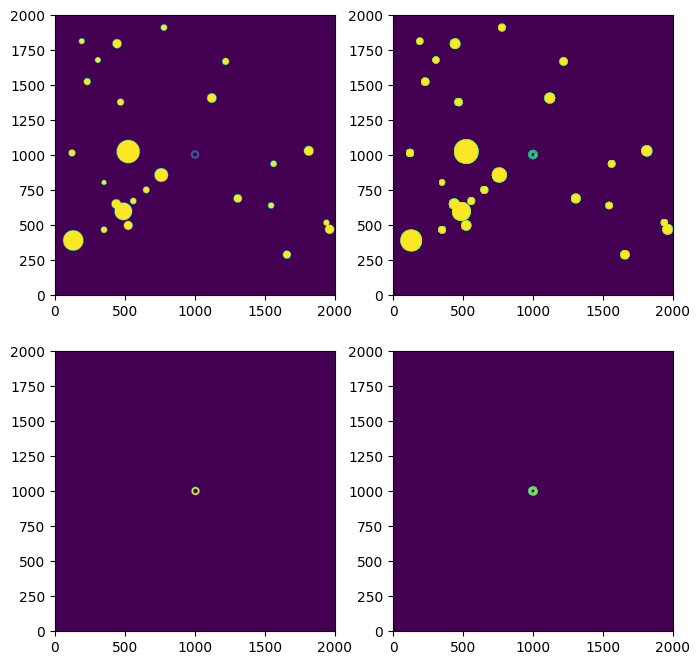

Total brightness inside the ring: 71.12229333054954
Total area of ring in pixels: 6016
Area to exclude: 0.0
Total brightness after filtering: 71.12229333054955
Total area of ring excluding masked regions: 6016.0


<Figure size 600x600 with 0 Axes>

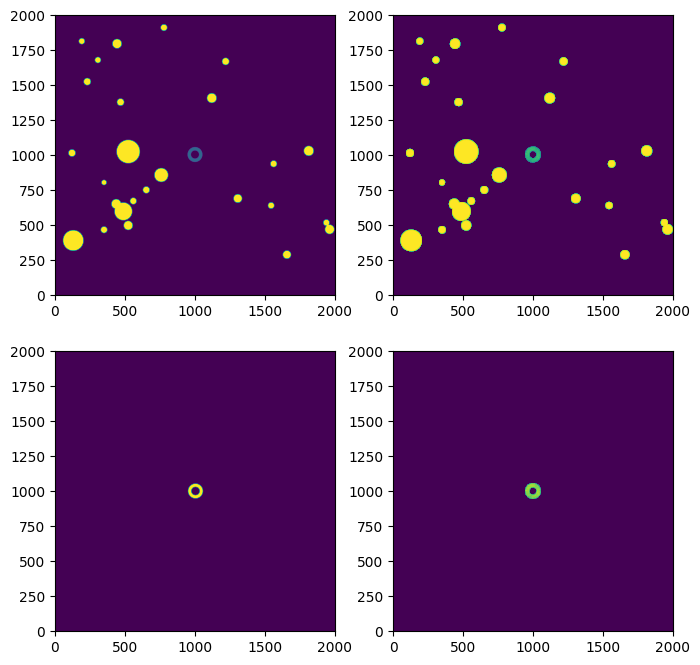

Total brightness inside the ring: 98.33862387831982
Total area of ring in pixels: 19576
Area to exclude: 0.0
Total brightness after filtering: 98.33862387831955
Total area of ring excluding masked regions: 19576.0


<Figure size 600x600 with 0 Axes>

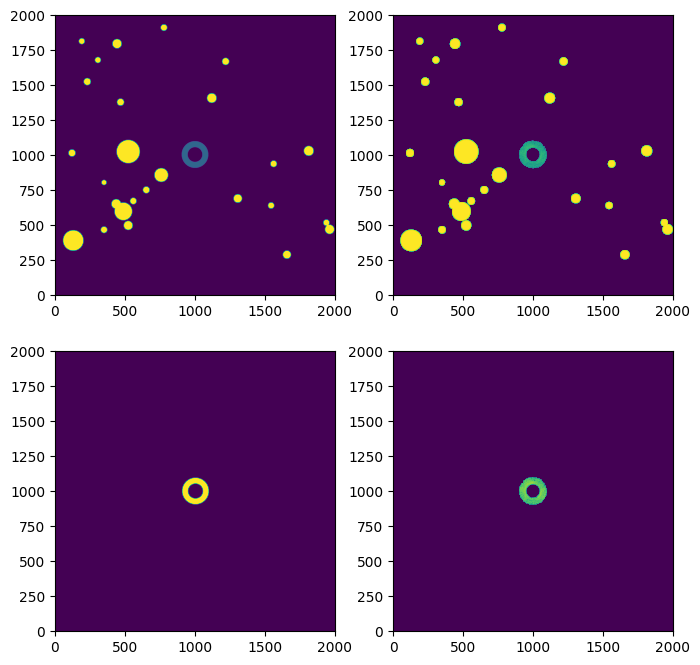

Total brightness inside the ring: 50.52615886148536
Total area of ring in pixels: 63532
Area to exclude: 0.0
Total brightness after filtering: 50.52615886148529
Total area of ring excluding masked regions: 63532.0


<Figure size 600x600 with 0 Axes>

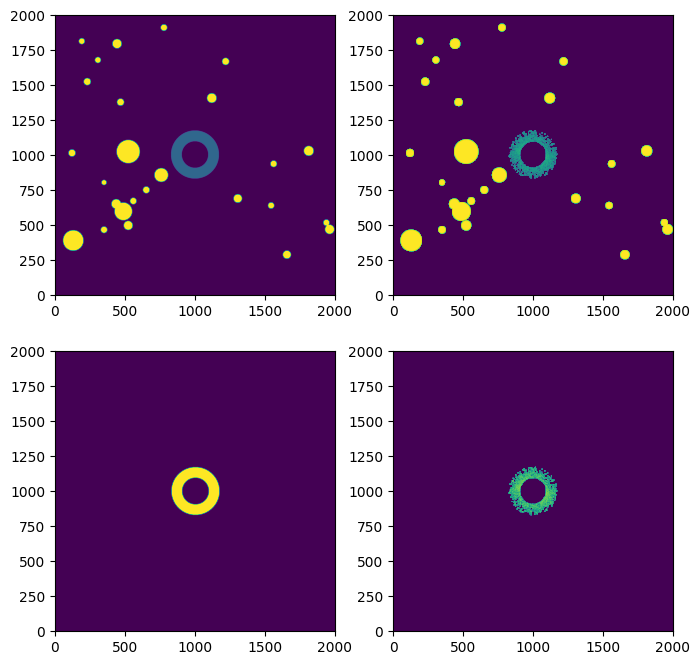

Total brightness inside the ring: 29.430704665300766
Total area of ring in pixels: 206324
Area to exclude: 6126.0
Total brightness after filtering: 18.165417594845728
Total area of ring excluding masked regions: 200198.0


<Figure size 600x600 with 0 Axes>

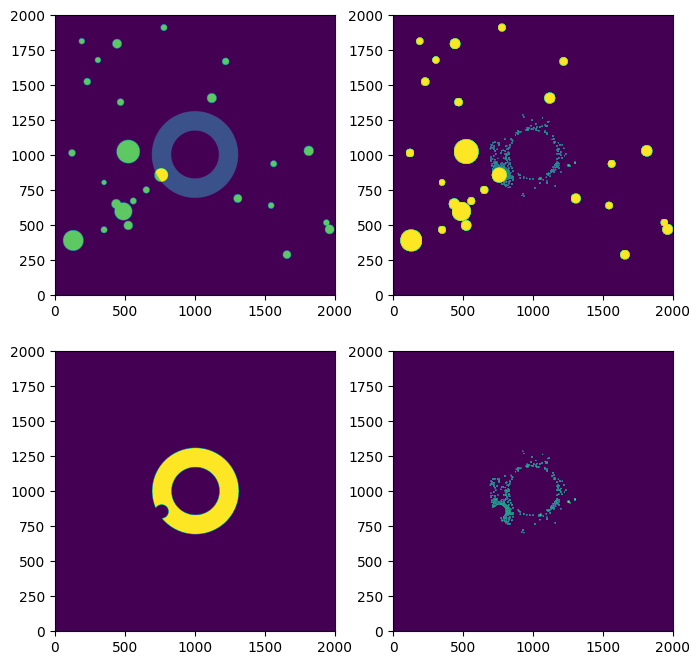

Total brightness inside the ring: 195.05022450967184
Total area of ring in pixels: 669728
Area to exclude: 32374.0
Total brightness after filtering: 69.48190740171275
Total area of ring excluding masked regions: 637354.0


<Figure size 600x600 with 0 Axes>

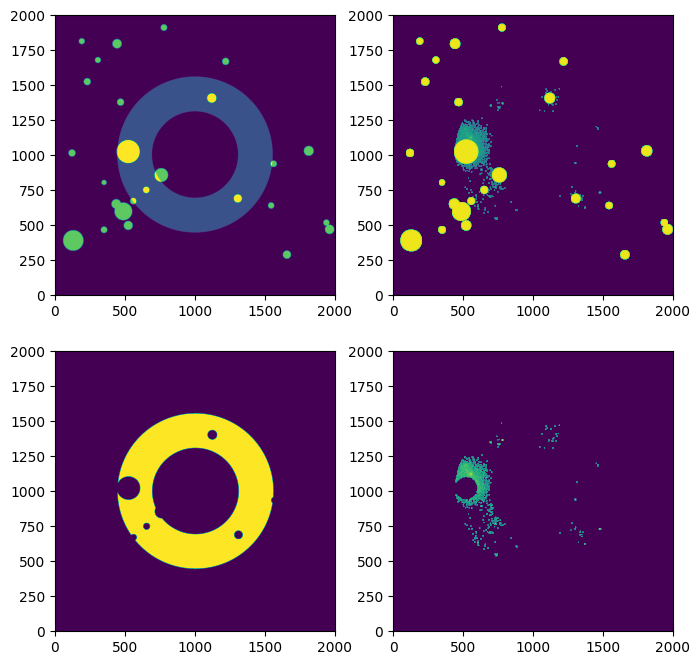

Total brightness inside the ring: 123.47758570945625
Total area of ring in pixels: 2173668
Area to exclude: 45917.0
Total brightness after filtering: 70.13688067573236
Total area of ring excluding masked regions: 2127751.0


<Figure size 600x600 with 0 Axes>

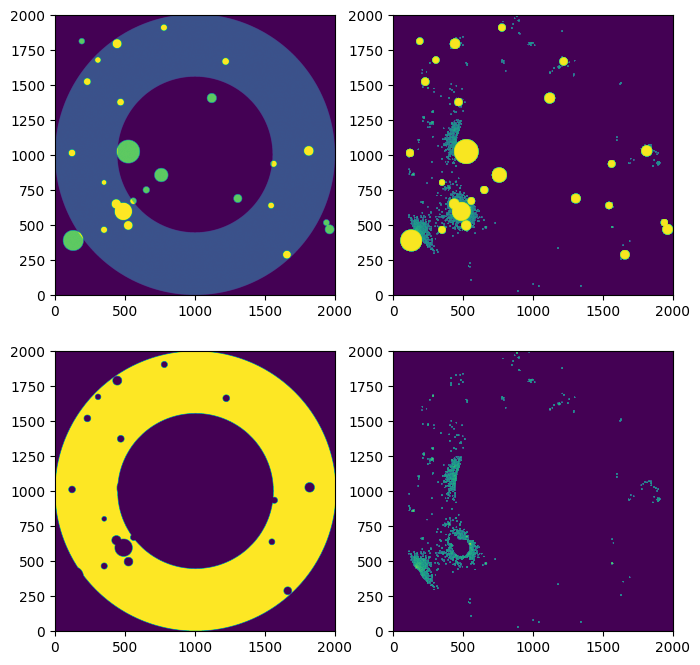

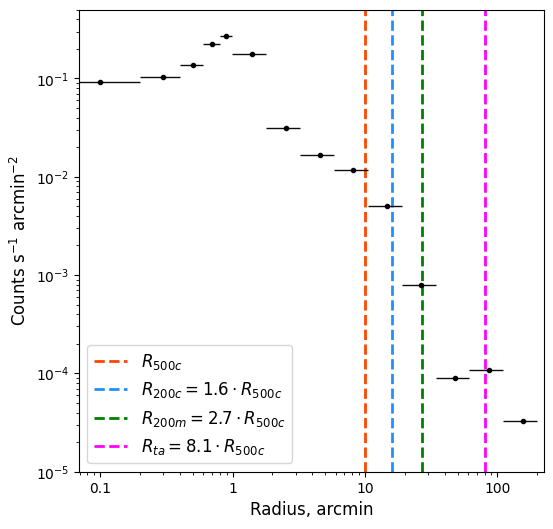

In [100]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=np.rot90(np.flip(tyty2)),
                          mmmask=np.rot90(np.flip(msk)),
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

### Calculating profiles for each cluster:

In [ ]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()yy

for cl_num in tqdm(clusters.index[:84]):

    pho_hist, mmaasskk = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=False,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(hist=pho_hist,
                              mmmask='no',
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-original.csv', sep=' ', header=False, index=True)

In [148]:
yarkosti = pd.read_csv("brpr-original.csv", sep='\s+', header=None, index_col=0)
display(yarkosti)
yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,,,,,,,,,,,,,,,,,,,,,
0,1.100628,1.538938,1.493736,1.185996,0.917406,0.635862,0.319347,0.192474,0.111875,0.076461,...,0.011150,0.006009,0.002579,0.000878,0.000227,3.979019e-05,2.150265e-05,6.574643e-05,1.351000e-04,1.627697e-04
0,0.161579,0.140519,0.096394,0.141284,0.133617,0.240524,0.365524,0.114539,0.041910,0.026266,...,0.005762,0.003769,0.002666,0.000933,0.000299,1.279758e-04,3.087739e-04,1.404233e-03,3.980953e-04,2.572256e-04
0,0.091494,0.103170,0.136513,0.224232,0.272761,0.276353,0.123283,0.046518,0.026968,0.020140,...,0.005141,0.002636,0.000910,0.000266,0.000067,1.560725e-04,1.608499e-04,3.571303e-04,8.945323e-05,3.684899e-05
0,0.048555,0.043425,0.057930,0.082135,0.092737,0.089660,0.103656,0.205771,0.130356,0.075556,...,0.009395,0.005303,0.003179,0.000870,0.000174,8.182431e-05,7.917636e-05,1.105809e-05,2.841036e-05,9.374194e-05
0,0.075548,0.173666,0.166429,0.363123,0.473390,0.666072,0.917639,0.415432,0.096811,0.062267,...,0.010851,0.006329,0.002788,0.001457,0.000445,5.610143e-05,8.381909e-05,2.234274e-04,7.678749e-05,3.141511e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.001243,0.001126,0.001260,0.001689,0.001380,0.001282,0.001485,0.001885,0.001950,0.001358,...,0.000440,0.000278,0.000149,0.000105,0.000029,6.549651e-06,9.549755e-06,1.123191e-05,6.670677e-06,2.229695e-06
0,0.000427,0.000703,0.000608,0.000443,0.000409,0.000499,0.000433,0.000511,0.000442,0.000531,...,0.000949,0.000194,0.000102,0.000052,0.000020,5.517159e-06,1.110309e-06,1.505490e-06,1.836270e-06,5.031328e-06
0,0.007765,0.007644,0.006744,0.003831,0.004498,0.003983,0.008453,0.018804,0.054443,0.016981,...,0.001446,0.001081,0.000628,0.000337,0.000173,7.251720e-05,2.221944e-05,3.382695e-05,3.894318e-05,2.336218e-06


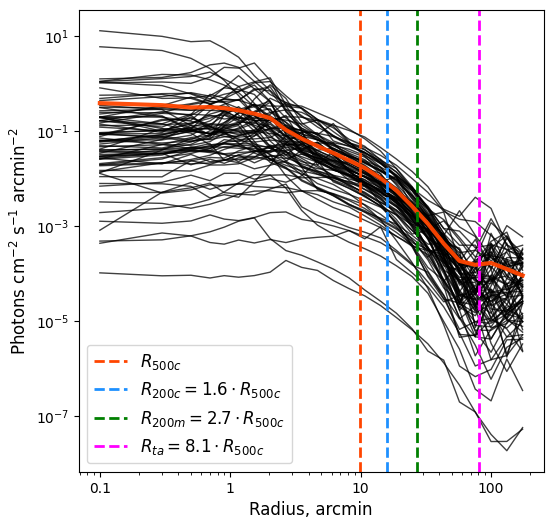

In [143]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/20)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[8])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Photons cm$^{{-2}}$ s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [112]:
%run -i 'utils/scripts.py'

length = 2001

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=False, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [119]:
total_hist = np.array(total_hist/84)

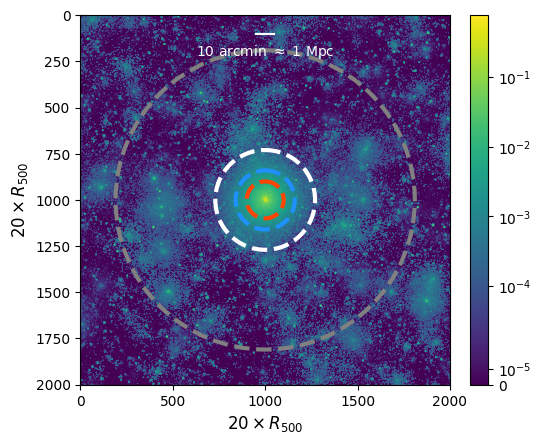

In [120]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=0.00005, linscale=1), 
           origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

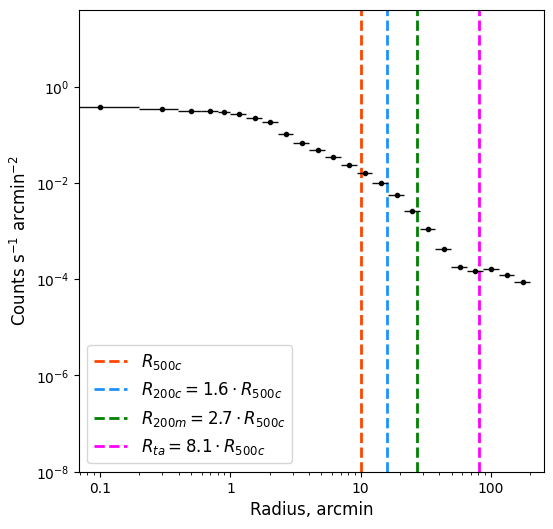

In [123]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=total_hist,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True)

plt.ylim(1e-8, 40)

plt.show()

### And now the same for filtered images:

In [ ]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[-7:-6]):

    pho_hist, mmaasskk = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=True,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(hist=pho_hist,
                              mmmask=mmaasskk,
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-masked.csv', sep=' ', header=False, index=True)

In [219]:
yarkosti = pd.read_csv("brpr-masked.csv", sep='\s+', header=None, index_col=0)
display(yarkosti)
yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,,,,,,,,,,,,,,,,,,,,,
0,1.100628,1.538938,1.493736,1.185996,0.917406,0.635862,0.319347,0.192474,0.111875,0.076461,...,0.011150,0.006009,0.002579,0.000878,0.000227,3.979019e-05,2.150265e-05,5.732093e-05,1.231083e-04,1.556410e-04
0,0.161579,0.140519,0.096394,0.141284,0.133617,0.240524,0.365524,0.114539,0.041910,0.026266,...,0.005762,0.003769,0.002666,0.000933,0.000299,6.547845e-05,2.105974e-04,2.205491e-04,1.220612e-04,7.686295e-05
0,0.091494,0.103170,0.136513,0.224232,0.272761,0.276353,0.123283,0.046518,0.026968,0.020140,...,0.005141,0.002636,0.000910,0.000266,0.000058,8.152420e-05,9.997049e-05,1.160876e-04,4.438273e-05,2.441727e-05
0,0.048555,0.043425,0.057930,0.082135,0.092737,0.089660,0.103656,0.205771,0.130356,0.075556,...,0.009395,0.005303,0.003179,0.000870,0.000174,8.168712e-05,7.878826e-05,7.718388e-06,1.859727e-05,6.285754e-05
0,0.075548,0.173666,0.166429,0.363123,0.473390,0.666072,0.917639,0.415432,0.096811,0.062267,...,0.010851,0.006329,0.002788,0.001457,0.000434,5.610143e-05,6.262814e-05,2.075407e-04,7.678749e-05,3.111689e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.001243,0.001126,0.001260,0.001689,0.001380,0.001282,0.001485,0.001885,0.001950,0.001358,...,0.000440,0.000266,0.000129,0.000097,0.000028,6.380935e-06,4.097270e-06,1.047412e-05,6.617940e-06,1.816566e-06
0,0.000427,0.000703,0.000608,0.000443,0.000409,0.000499,0.000433,0.000511,0.000442,0.000531,...,0.000966,0.000187,0.000099,0.000052,0.000019,5.509502e-06,1.110309e-06,1.455426e-06,1.306339e-06,4.850202e-06
0,0.007765,0.007644,0.006744,0.003831,0.004498,0.003983,0.008453,0.018804,0.054443,0.016981,...,0.001446,0.001081,0.000628,0.000337,0.000173,7.251720e-05,2.221944e-05,3.382695e-05,3.894318e-05,2.336218e-06


In [220]:
yarkosti[11]

array([6.05161425e-02, 8.25379081e-02, 1.05035090e-01, 1.12729327e-01,
       1.48933208e-01, 2.32243591e-01, 3.57947922e-01, 2.77312078e-01,
       1.47580644e-01, 7.39532769e-02, 4.47556224e-02, 3.20390276e-02,
       2.32060031e-02, 1.62804773e-02, 1.26729152e-02, 4.09247728e-03,
       1.81142670e-03, 5.45687721e-04, 1.22779378e-04, 1.64510981e-05,
       3.85792953e-05, 7.49281152e-05, 1.32556166e-05, 4.72251498e-05])

In [221]:
yarkosti[10]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.29195558e-02, 2.15925849e-01, 2.16797671e-01,
       1.47036472e-01, 1.06857885e-01, 1.03989162e-01, 8.81811888e-02,
       6.48859771e-02, 3.18749093e-02, 1.70625800e-02, 7.19835878e-03,
       2.50677713e-03, 6.87684634e-04, 6.31594220e-04, 9.29616141e-04,
       2.72295871e-04, 2.12505530e-04, 1.27016509e-04, 1.49948149e-04])

<Figure size 640x480 with 0 Axes>

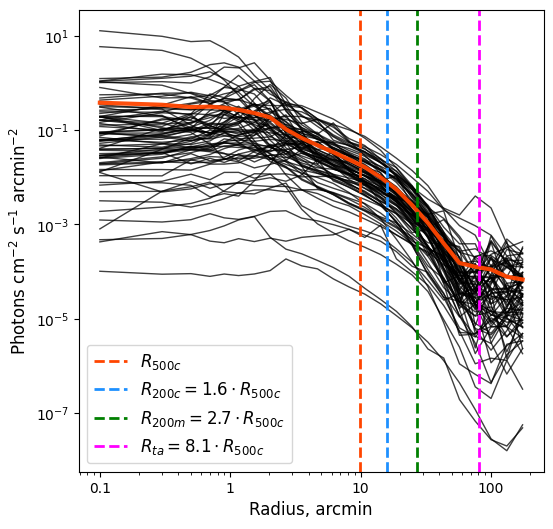

In [225]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/20)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[0])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
    
    yar = yar + one
    
    if one[-1]==np.nan:
        llww=10
        
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Photons cm$^{{-2}}$ s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [226]:
%run -i 'utils/scripts.py'

length = 2001

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist, mskk = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=True, 
                                            histlen=2001, 
                                            ARF_weights=True)
    f = np.sum(mskk)/2000/2000
    print(f)
    
    total_hist = np.array(total_hist)*(1-f)
    
    total_hist = np.add(total_hist, pho_hist*(1-mskk))

  0%|          | 0/84 [00:00<?, ?it/s]

0.01866
0.03579325
0.026748
0.0082935
0.00788825
0.01985525
0.011143499999999999
0.0099445
0.0074962499999999994
0.013257
0.025577000000000003
0.00658875
0.01346375
0.035246
0.00841025
0.020180499999999997
0.021941
0.032245499999999996
0.0104235
0.025258500000000003
0.009866
0.0046845
0.01826825
0.014535
0.00245675
0.02776775
0.014324249999999998
0.011104
0.010703250000000001
0.01227825
0.019589500000000003
0.006023
0.00437
0.0094885
0.0117345
0.0083215
0.016665500000000003
0.003379
0.01228525
0.01423575
0.0130245
0.002511
0.0163575
0.015223750000000001
0.009963749999999999
0.01050775
0.013033
0.01115775
0.00656075
0.0121925
0.015363
0.012406750000000001
0.0142995
0.005851
0.0063869999999999994
0.0071585
0.004284
0.00456275
0.0075910000000000005
0.00818175
0.005528
0.0067374999999999996
0.00742875
0.011691499999999999
0.013336
0.00840075
0.0140985
0.003915500000000001
0.012044000000000001
0.01228925
0.0014830000000000002
0.0075060000000000005
0.005755
0.019463499999999998
0.02709225
0.

<Figure size 640x480 with 0 Axes>

In [227]:
total_hist = np.array(total_hist/84)

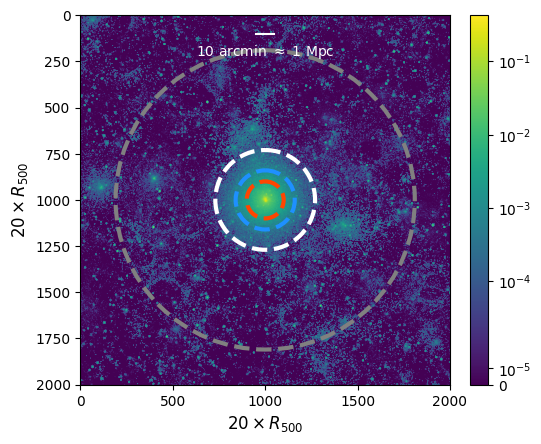

In [228]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=0.00005, linscale=1), 
           origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

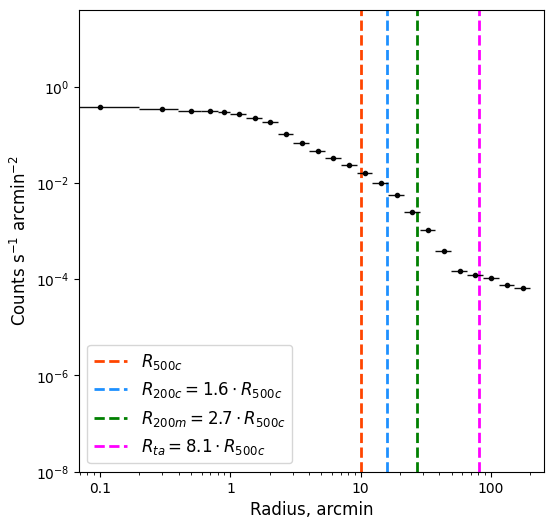

In [180]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=total_hist,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True)

plt.ylim(1e-8, 40)

plt.show()

### Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

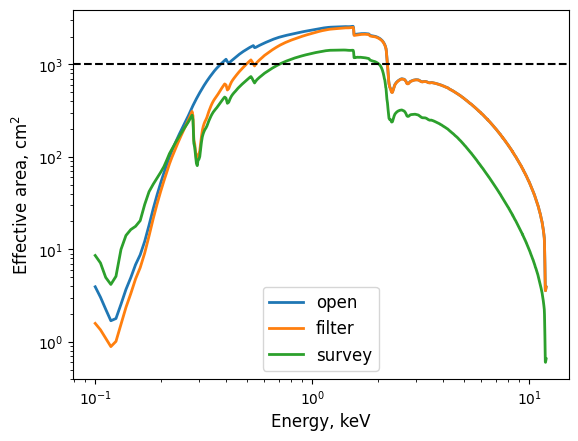

In [190]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

#### The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [191]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [193]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014
